# Nestle - Zadanie Rekturacyjne
## Business Case - Data Science Hub
### Autor: Szymon Baczyński

## 1. Wczytanie danych i przegląd
### Pliki treningowe: X_train.csv & Y_train.csv
### Pliki testowe: X_test.csv & Y_test.csv

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime
import requests
import IPython.display as Disp
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Wczytanie danych i szybki przeglad
X_train = pd.read_csv("X_train.csv", delimiter= ";", decimal=",")
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8437 entries, 0 to 8436
Columns: 114 entries, key to x112
dtypes: float64(112), int64(1), object(1)
memory usage: 7.3+ MB


,key,date,x1,x2,x3,x4,x5,x6,x7,x8,...,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112
0,683,01Jan2012,0.793085,0.000000,0.690346,0.000000,NaN,NaN,502.893893,10235.637780,...,0.053509,120.669814,0.955509,616.883023,200.144478,0.0,20.391554,0.509713,216.851245,56.139906
1,683,01Feb2012,0.000000,0.000686,0.590133,0.000000,362.021309,NaN,72.833160,88.793012,...,112.074385,69.943189,2.704237,292.934714,138.241134,0.0,15.316564,2.526962,39.451960,7.172635
2,683,01Mar2012,0.000000,0.000000,0.000000,0.672651,NaN,NaN,880.917406,553.998042,...,0.998247,273.213135,0.000000,92.264811,100.972356,0.0,12.774053,0.242973,35.226264,50.614383
3,683,01Apr2012,0.000000,0.000000,0.000000,0.022906,NaN,6.711943,150.778812,11.951856,...,182.047997,18.272077,-0.357520,5.272196,49.725924,0.0,17.904427,29.437773,5.591309,0.000000
4,683,01May2012,0.000000,0.000000,0.000000,0.000000,NaN,NaN,5116.833341,114.048014,...,15.836277,1629.479264,59.613338,0.060753,4.878556,0.0,14.081303,0.125393,5.872891,0.000000


In [4]:
# ID produktow w danych treningowych
X_train.key.unique()

array([  683,   894,  2831,  2835,  4361,  6846,  8200,  8284,  8507,
        8992,  9822,  9902, 10638, 10873, 11438, 12429, 12851, 13142,
       14208, 15684, 16071, 16288, 16764, 18726, 18769, 19961, 19983,
       20118, 20423, 22658, 23001, 23155, 23620, 24248, 24488, 25608,
       26405, 30503, 31088, 32360, 32462, 32473, 36516, 37081, 39686,
       39943, 40698, 42401, 43045, 44612, 44732, 45363, 47742, 48722,
       48768, 51983, 52602, 55896, 56059, 57423, 59676, 59945, 60270,
       61127, 61305, 61370, 61485, 62490, 65101, 65256, 65418, 65919,
       66606, 66668, 68521, 70444, 72159, 72802, 73255, 74321, 74523,
       74703, 74813, 75040, 75309, 75315, 76407, 76600, 76872, 77390,
       77827, 77887, 79649, 79659, 79672, 79912, 80276, 80876, 81283,
       81879, 82761, 83838, 84908, 84948, 86250, 86430, 86537, 86719,
       87547, 87586, 88848, 90929, 93876, 95121, 96037, 97021, 97392,
       98721, 99444], dtype=int64)

In [5]:
# Ilosc unikalnych produktow
X_train.key.nunique()

119

In [6]:
# Sprawdzenie zakresu dat
X_train.date.unique()

array(['01Jan2012', '01Feb2012', '01Mar2012', '01Apr2012', '01May2012',
       '01Jun2012', '01Jul2012', '01Aug2012', '01Sep2012', '01Oct2012',
       '01Nov2012', '01Dec2012', '01Jan2013', '01Feb2013', '01Mar2013',
       '01Apr2013', '01May2013', '01Jun2013', '01Jul2013', '01Aug2013',
       '01Sep2013', '01Oct2013', '01Nov2013', '01Dec2013', '01Jan2014',
       '01Feb2014', '01Mar2014', '01Apr2014', '01May2014', '01Jun2014',
       '01Jul2014', '01Aug2014', '01Sep2014', '01Oct2014', '01Nov2014',
       '01Dec2014', '01Jan2015', '01Feb2015', '01Mar2015', '01Apr2015',
       '01May2015', '01Jun2015', '01Jul2015', '01Aug2015', '01Sep2015',
       '01Oct2015', '01Nov2015', '01Dec2015', '01Jan2016', '01Feb2016',
       '01Mar2016', '01Apr2016', '01May2016', '01Jun2016', '01Jul2016',
       '01Aug2016', '01Sep2016', '01Oct2016', '01Nov2016', '01Dec2016',
       '01Jan2017', '01Feb2017', '01Mar2017', '01Apr2017', '01May2017',
       '01Jun2017', '01Jul2017', '01Aug2017', '01Sep2017', '01Oc

In [8]:
# Sprawdzenie co sie dzieje w danych - nowe produkty (w czasie) + zmienna ilosc danych dla poszczegolnych produktow
X_train.groupby('key').count()

,date,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112
key,,,,,,,,,,,,,,,,,,,,,
683,78,71,73,74,74,21,30,73,71,71,...,73,73,73,73,73,73,78,73,73,73
894,66,56,59,64,64,24,23,60,56,56,...,59,59,59,64,64,64,66,64,64,64
2831,78,70,70,71,65,32,26,67,70,70,...,68,70,68,66,67,67,78,69,67,69
2835,78,63,69,72,71,28,24,70,62,63,...,69,69,69,73,73,73,0,73,73,73
4361,78,71,75,70,72,25,25,71,71,71,...,75,75,75,72,73,73,78,73,73,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96037,66,62,56,62,61,14,27,64,62,62,...,57,56,57,60,60,60,66,60,60,60
97021,78,75,77,66,73,22,26,70,75,75,...,77,77,77,74,74,74,78,74,74,74
97392,78,70,74,70,73,19,33,71,70,70,...,74,74,74,76,76,76,78,75,76,75


In [9]:
# Ile jest wartosci  w poszczegolnych kolumnach
X_train.isnull().sum()

key       0
date      0
x1      637
x2      644
x3      640
       ... 
x108    620
x109    632
x110    617
x111    620
x112    619
Length: 114, dtype: int64

In [10]:
# Sprawdzmy przy okazji dane "target" - "Y"
Y_train = pd.read_csv("Y_train.csv", delimiter= ";", decimal=",")
Y_train.info()
Y_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8437 entries, 0 to 8436
Data columns (total 3 columns):
key     8437 non-null int64
date    8437 non-null object
y       8396 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 197.9+ KB


,key,date,y
0,683,01Jan2012,1430.314968
1,683,01Feb2012,0.000000
2,683,01Mar2012,5088.531900
3,683,01Apr2012,2837.756051
4,683,01May2012,51.311689


In [11]:
Y_train.isnull().sum()

key      0
date     0
y       41
dtype: int64

In [13]:
Y_train.groupby('key').count()

key
683      78
894      66
2831     78
2835     78
4361     78
         ..
96037    66
97021    78
97392    78
98721    78
99444    78
Name: date, Length: 119, dtype: int64

In [17]:
# Sprawdzmy czy ilosc miesiecy dla X i Y w zbiorze treningowym sie zgadzaja
all(X_train.groupby('key').count().date == Y_train.groupby('key').count().date)

True

In [ ]:
# Zduplikowane wiersze?
# https://stackoverflow.com/questions/50242968/check-for-duplicate-values-in-pandas-dataframe-column

## 2. Data Wrangling - zróbmy z tego dane, które da się czytać

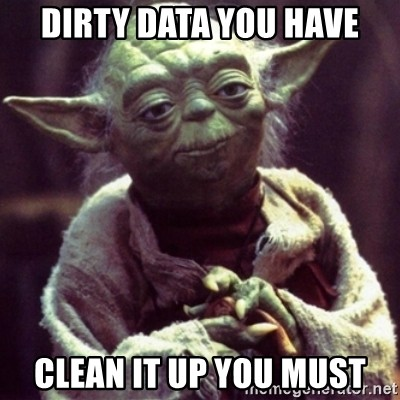

In [31]:
url = 'https://miro.medium.com/max/400/0*TXDoF8j-D3LuGbHP.jpg'
Disp.Image(requests.get(url).content)